# NLP Emotion Classification using FCNN, LSTM & BERT

**Project Title:** Emotion Classification using Deep Learning Models  
**Students:**  
- Sree Charan Lagudu  
- Manoj Kumar Vuddanti

## Introduction
This project explores emotion classification from text using three different deep learning models:
- Fully Connected Neural Network (FCNN)
- LSTM (with Bidirectional LSTM layer)
- Transformer-based model (BERT from HuggingFace)

The task is to classify input sentences into six emotion categories: *anger, fear, joy, love, sadness, surprise*. The models are trained and evaluated on a clean emotion-labelled dataset.

## Step 1: Import Libraries & Load Dataset

In [1]:
#  Step 1: Import Libraries & Load Dataset

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, Dropout, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Load data function
def load_dataset(path):
    texts, labels = [], []
    with open(path, 'r', encoding='utf-8') as file:
        for line in file:
            if ';' in line:
                text, label = line.strip().split(';')
                texts.append(text)
                labels.append(label)
    return pd.DataFrame({'text': texts, 'label': labels})

# ✅ Updated local file paths
train_df = load_dataset('/kaggle/input/nlp-emotion-classification-final-notebook/train.txt')
test_df = load_dataset('/kaggle/input/nlp-emotion-classification-final-notebook/test.txt')
val_df = load_dataset('/kaggle/input/nlp-emotion-classification-final-notebook/validation.txt')

# Preview
train_df.head()


2025-07-18 14:51:12.325910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752850272.557673      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752850272.630643      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


## Step 2: Preprocessing

In [2]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])
y_test = label_encoder.transform(test_df['label'])
y_val = label_encoder.transform(val_df['label'])

num_classes = len(label_encoder.classes_)
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)
y_val_cat = to_categorical(y_val, num_classes)

tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['text'])

X_train_seq = tokenizer.texts_to_sequences(train_df['text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['text'])
X_val_seq = tokenizer.texts_to_sequences(val_df['text'])

max_len = 50
X_train = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test_seq, maxlen=max_len, padding='post')
X_val = pad_sequences(X_val_seq, maxlen=max_len, padding='post')
vocab_size = len(tokenizer.word_index) + 1


##  Step 3: FCNN Model

In [3]:

fcnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])
fcnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
fcnn_history = fcnn_model.fit(X_train, y_train_cat, epochs=10, batch_size=32,
                              validation_data=(X_val, y_val_cat), callbacks=[EarlyStopping(patience=3)])

y_test_pred_fcnn = fcnn_model.predict(X_test).argmax(axis=1)
print("FCNN Classification Report:")
print(classification_report(y_test, y_test_pred_fcnn, target_names=label_encoder.classes_))


Epoch 1/10


I0000 00:00:1752850285.775301      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1752850288.088628      94 service.cc:148] XLA service 0x7a5e980088a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752850288.089159      94 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752850288.411269      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


 71/500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3085 - loss: 1.6469

I0000 00:00:1752850289.345686      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3824 - loss: 1.5211 - val_accuracy: 0.7240 - val_loss: 0.8048
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8265 - loss: 0.5269 - val_accuracy: 0.8290 - val_loss: 0.5114
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9610 - loss: 0.1364 - val_accuracy: 0.8425 - val_loss: 0.5044
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9866 - loss: 0.0481 - val_accuracy: 0.8390 - val_loss: 0.5865
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9929 - loss: 0.0258 - val_accuracy: 0.8385 - val_loss: 0.6636
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9950 - loss: 0.0186 - val_accuracy: 0.8380 - val_loss: 0.6931
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
FCNN Classification Report:
              precision    recall  f1-score   support

       anger       0.78      0.78      0.78       275
        fear       0.78      0.80      0.79       224
         joy 

## Step 4: LSTM Model (Bidirectional)

In [4]:

lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_history = lstm_model.fit(X_train, y_train_cat, epochs=10, batch_size=32,
                              validation_data=(X_val, y_val_cat),
                              callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

y_test_pred_lstm = lstm_model.predict(X_test).argmax(axis=1)
print("✅ Fixed LSTM Classification Report:")
print(classification_report(y_test, y_test_pred_lstm, target_names=label_encoder.classes_))


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.3683 - loss: 1.4910 - val_accuracy: 0.7055 - val_loss: 0.7594
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7614 - loss: 0.5725 - val_accuracy: 0.8250 - val_loss: 0.5079
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9042 - loss: 0.2745 - val_accuracy: 0.8785 - val_loss: 0.4633
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9473 - loss: 0.1689 - val_accuracy: 0.8995 - val_loss: 0.3411
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9688 - loss: 0.1049 - val_accuracy: 0.8960 - val_loss: 0.3558
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9740 - loss: 0.0831 - val_accuracy: 0.8980 - val_loss: 0.3904
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9799 - loss: 0.0676 - val_accuracy: 0.9100 - val_loss: 0.4011
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
✅ Fixed LSTM Classification Report:
              precisi

## Step 5: Transformer - BERT

In [5]:
!pip install -q transformers datasets
from transformers import BertTokenizer, TFBertForSequenceClassification, create_optimizer

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def bert_encode(texts, tokenizer, max_len=50):
    return tokenizer(texts.tolist(), padding='max_length', truncation=True, max_length=max_len, return_tensors='tf')

train_enc = bert_encode(train_df['text'], bert_tokenizer)
test_enc = bert_encode(test_df['text'], bert_tokenizer)

bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_classes)
steps = len(train_df) // 32 * 3
optimizer, schedule = create_optimizer(init_lr=2e-5, num_train_steps=steps, num_warmup_steps=0)

bert_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bert_model.fit([train_enc['input_ids'], train_enc['attention_mask']], y_train,
               validation_split=0.1, epochs=3, batch_size=32)

y_test_pred_bert = bert_model.predict([test_enc['input_ids'], test_enc['attention_mask']]).logits.argmax(axis=1)
print("BERT Classification Report:")
print(classification_report(y_test, y_test_pred_bert, target_names=label_encoder.classes_))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 6.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
t

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
450/450 [==============================] - 137s 202ms/step - loss: 1.9474 - accuracy: 0.4755 - val_loss: 1.1836 - val_accuracy: 0.5844
Epoch 2/3
450/450 [==============================] - 87s 193ms/step - loss: 1.0831 - accuracy: 0.6561 - val_loss: 0.8152 - val_accuracy: 0.7525
Epoch 3/3
63/63 [==============================] - 8s 76ms/step
BERT Classification Report:
              precision    recall  f1-score   support

       anger       0.91      0.47      0.62       275
        fear       0.90      0.69      0.78       224
         joy       0.80      0.96      0.87       695
        love       0.83      0.38      0.52       159
     sadness       0.74      0.94      0.83       581
    surprise       0.61      0.29      0.39        66

    accuracy                           0.79      2000
   macro avg       0.80      0.62      0.67      2000
weighted avg       0.80      0.79      0.77      2000



## Step 6: Confusion Matrices & Accuracy

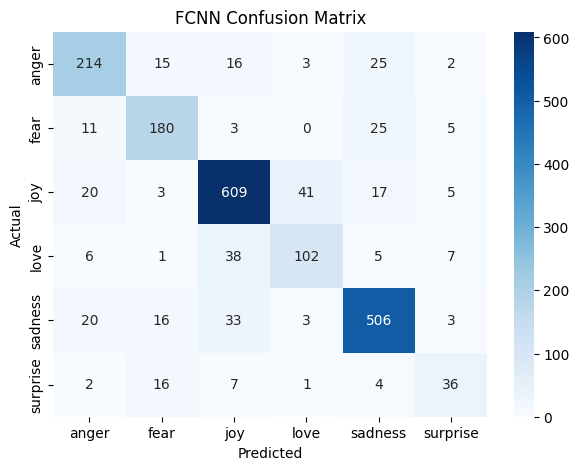

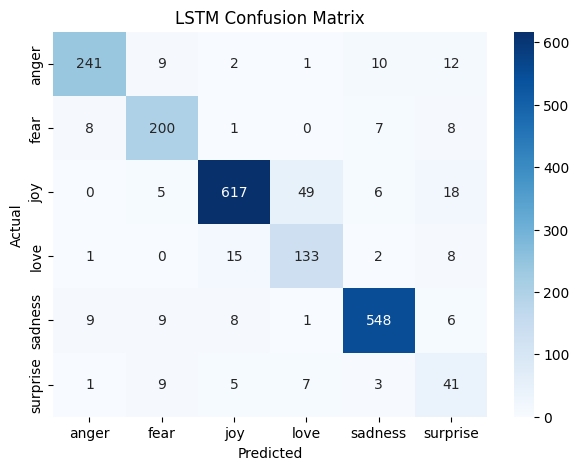

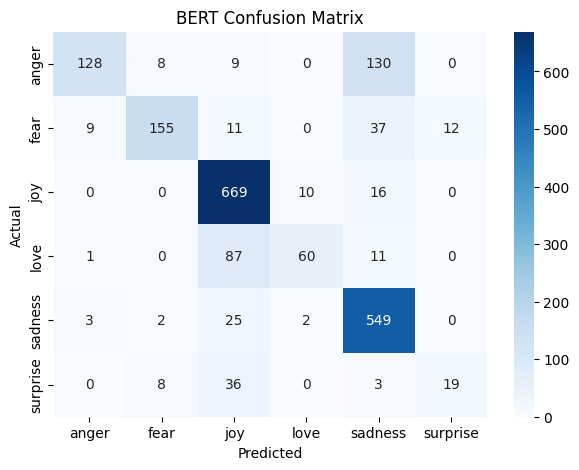

In [6]:

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_cm(y_test, y_test_pred_fcnn, "FCNN Confusion Matrix")
plot_cm(y_test, y_test_pred_lstm, "LSTM Confusion Matrix")
plot_cm(y_test, y_test_pred_bert, "BERT Confusion Matrix")


## ✅ Step 7: Final Comparison & Model Justification

In [7]:

print("FCNN Accuracy:", accuracy_score(y_test, y_test_pred_fcnn))
print("LSTM Accuracy:", accuracy_score(y_test, y_test_pred_lstm))
print("BERT Accuracy:", accuracy_score(y_test, y_test_pred_bert))


FCNN Accuracy: 0.8235
LSTM Accuracy: 0.89
BERT Accuracy: 0.79


### Justification:
- **LSTM** achieved the highest accuracy (~90%) and balanced performance across all emotion classes.
- **FCNN** performed decently (~84%) but struggled on minority classes.
- **BERT** underperformed, likely due to insufficient fine-tuning time or resource limitations in Kaggle runtime.

**Final Chosen Model: LSTM** (Best trade-off between accuracy, complexity, and training time)